# Yuumi Insurance EDA

# Plan


todo:
--------

add more models - neel/dean/serena

unsure if completed properly
---------

Group by new id - neel

In [1]:
# import basic libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
%matplotlib inline

# data visualisation
import seaborn as sns
sns.set(font_scale=2)
plt.style.use('seaborn-whitegrid')

# preprocessing - encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from nltk.tokenize import WordPunctTokenizer
import json
from pandas.io.json import json_normalize
#json_normalize(msgLog['message'])

# make column width bigger when displaying columns
pd.set_option("display.max_colwidth", 1000)
# display more columns
pd.set_option("display.max_columns", None)
# format float display
pd.options.display.float_format = '{:.2f}'.format

#regex
import re

#package for cell runtime (dev only)
!pip install ipython-autotime
%load_ext autotime

-----
# Part 1: Clean/Process Data
-----

In [2]:
log = pd.read_csv('Dataset/data.csv')

time: 23.2 s


In [3]:
# shows columns and the data types of columns
# message       object
# timestamp    float64
# dtype: object
# note object = string
#log.dtypes
# df with 3301834 rows
# len(log)
# look at data, we can check the columns by log.message/log.timestamp
# also log.message[0] shows first value for log.message
log.head(20)

,message,timestamp
0,8f70c7577be8483 - mobile_browser - Quote Started for customer: 99ccf1,1483192800.00
1,"1368d40a4f6e455 - mobile_browser - Quote Completed for customer: 99ccf1 with json payload {'name': 'Nicole Berry', 'email': 'Nicole Berry@hotmail.com', 'gender': 'male', 'age': 29, 'home': {'type': 1, 'square_footage': 311.80361967382737, 'number_of_bedrooms': 2, 'number_of_floors': 1}, 'household': [{'name': 'Oscar Berry', 'age': 25, 'gender': 'female'}, {'name': 'Mark Berry', 'age': 10, 'gender': 'female'}, {'name': 'Jacqueline Berry', 'age': 14, 'gender': 'male'}], 'address': '66 Lake Jamieview,PSC '}",1483193676.51
2,90527688b31d445 - mobile_browser - Claim Started for customer: 99ccf1,1483193794.69
3,c4013f44ea6d40c - mobile_browser - Payment Completed for customer: 99ccf1,1483193794.69
4,8045614075e7466 - pc_browser - Quote Started for customer: 9bae09,1483196400.00
5,"6859e40fdc3f40d - pc_browser - Quote Completed for customer: 9bae09 with json payload {'name': 'Brandi Harris', 'email': 'Brandi Harris@duncan.com', 'gender': 'male', 'age': 62, 'home': {'type': 1, 'square_footage': 523.4329572865342, 'number_of_bedrooms': 2, 'number_of_floors': 1}, 'household': [{'name': 'Michael Harris', 'age': 12, 'gender': 'male'}, {'name': 'Michael Harris', 'age': 7, 'gender': 'male'}], 'address': '60 West Lisaside, Jamie Port Suite '}",1483197036.47
6,4c9ab2942b484f2 - pc_browser - Claim Started for customer: 9bae09,1483197184.51
7,07ba7defa6444ba - pc_browser - Payment Completed for customer: 9bae09,1483197184.51
8,cb6d5db3f2ce478 - pc_browser - Quote Started for customer: 12fdce,1483199674.68
9,0ddb305e024d49f - pc_browser - Quote Started for customer: b7aab4,1483200000.00


time: 49 ms


In [4]:
# the log is sorted in icreasing order 
log['timestamp'].is_monotonic 

True

time: 31.4 ms


split the message column into multiple columns, transaction_id, action, customer_id, action, message

In [5]:
# create msgLog for manipulating message data
msgLog = pd.DataFrame()

#msgLog['message'] = log['message']
msgLog['transaction_id'], msgLog['device'], msgLog['message'] = log['message'].str.split('-',2).str
msgLog['action'], msgLog['message'] = msgLog['message'].str.split(':',1).str
msgLog['customer_id'], msgLog['message'] = msgLog['message'].str.split(n=1).str
msgLog['action'] = msgLog['action'].str.strip()

#msgLog['message'] = msgLog['message'].str.split('json payload',1).str[0]
msgLog['message'], msgLog['json_payload'] = msgLog['message'].str.split('json payload',1).str

msgLog['timestamp'] = log['timestamp']

time: 46 s


In [6]:
msgLog.head()

,transaction_id,device,message,action,customer_id,json_payload,timestamp
0,8f70c7577be8483,mobile_browser,NaN,Quote Started for customer,99ccf1,NaN,1483192800.00
1,1368d40a4f6e455,mobile_browser,with,Quote Completed for customer,99ccf1,"{'name': 'Nicole Berry', 'email': 'Nicole Berry@hotmail.com', 'gender': 'male', 'age': 29, 'home': {'type': 1, 'square_footage': 311.80361967382737, 'number_of_bedrooms': 2, 'number_of_floors': 1}, 'household': [{'name': 'Oscar Berry', 'age': 25, 'gender': 'female'}, {'name': 'Mark Berry', 'age': 10, 'gender': 'female'}, {'name': 'Jacqueline Berry', 'age': 14, 'gender': 'male'}], 'address': '66 Lake Jamieview,PSC '}",1483193676.51
2,90527688b31d445,mobile_browser,NaN,Claim Started for customer,99ccf1,NaN,1483193794.69
3,c4013f44ea6d40c,mobile_browser,NaN,Payment Completed for customer,99ccf1,NaN,1483193794.69
4,8045614075e7466,pc_browser,NaN,Quote Started for customer,9bae09,NaN,1483196400.00


time: 17.3 ms


In [7]:
msgLog[msgLog['customer_id']=='1c8f1f']

,transaction_id,device,message,action,customer_id,json_payload,timestamp
793703,d5322d37720947f,mobile_browser,NaN,Quote Started for customer,1c8f1f,NaN,1503617419.30
793742,858f621b2c94432,mobile_browser,with,Quote Completed for customer,1c8f1f,"{'name': 'Brooke Mendez', 'email': 'Brooke Mendez@gmail.com', 'gender': 'female', 'age': 29, 'home': {'type': 0, 'square_footage': 183.035681535314, 'number_of_bedrooms': 3, 'number_of_floors': 1}, 'household': [{'name': 'Russell Mendez', 'age': 29, 'gender': 'female'}], 'address': '117 Andersonborough, Matthew Club Suite '}",1503618268.31
793752,228184ae36d64ae,mobile_browser,NaN,Payment Completed for customer,1c8f1f,NaN,1503618406.90
1015700,e9126660957c4ed,mobile_browser,NaN,Claim Started for customer,1c8f1f,NaN,1507941720.93
1062240,7557623d25be4fa,mobile_browser,NaN,Claim Started for customer,1c8f1f,NaN,1508811153.86
1067735,016e27e93301492,mobile_browser,- paid $5575.89,Claim Accepted for customer,1c8f1f,NaN,1508917766.89
1208871,5316bbad015345b,mobile_browser,- paid $5575.89,Claim Accepted for customer,1c8f1f,NaN,1511582773.95
1581191,d5c596f839b84f8,mobile_browser,NaN,Claim Started for customer,1c8f1f,NaN,1518261958.25
1760168,a377559224904b0,mobile_browser,- paid $5575.89,Claim Accepted for customer,1c8f1f,NaN,1521337696.38
2385620,beaa723be0a44df,mobile_browser,NaN,Claim Started for customer,1c8f1f,NaN,1531748003.49


time: 1.37 s


Drop the transaction column cos its fucking useless, can count number of transactions by actions

In [8]:
# all transaction id's are unique, not very useful
# msgLog.transaction_id.value_counts()
msgLog = msgLog.drop(columns=['transaction_id'])

time: 547 ms


In [9]:
# 621123 unique ids, note that some customer ids are repeated
len(msgLog.customer_id.value_counts())

621123

time: 1.98 s


Sort values by customer id (thereby grouping by customer id, but not reducing rows)

In [10]:
msgLog = msgLog.sort_values(by=['customer_id', 'timestamp'], kind = 'mergesort')
msgLog = msgLog.reset_index(drop=True)

time: 10.8 s


In [11]:
# add paid dataframe to msgLog
paid = pd.DataFrame()
msgLog['message'], msgLog['paid'] = msgLog['message'].str.split('$').str
msgLog['paid'] = pd.to_numeric(msgLog['paid'])

time: 7.32 s


In [12]:
msgLog.message.value_counts()

- paid              816301
with                632998
- reason : fraud     10494
Name: message, dtype: int64

time: 934 ms


In [13]:
print(np.nanmin(msgLog['paid']), np.nanmax(msgLog['paid']), np.nanmean(msgLog['paid']))

2642.61 27097.44 8710.884242638436
time: 118 ms


In [14]:
# backup good msgLog
#1*
backupMsgLog = msgLog.copy()

time: 575 ms


In [15]:
msgLog.head()

,device,message,action,customer_id,json_payload,timestamp,paid
0,mobile_app,NaN,Quote Started for customer,000012,NaN,1520515553.72,nan
1,mobile_app,with,Quote Completed for customer,000012,"{'name': 'Kimberly Mathews', 'email': 'Kimberly Mathews@hotmail.com', 'gender': 'male', 'age': 53, 'home': {'type': 1, 'square_footage': 346.20595281589794, 'number_of_bedrooms': 5, 'number_of_floors': 1}, 'household': [{'name': 'Kristen Mathews', 'age': 14, 'gender': 'female'}, {'name': 'Randy Mathews', 'age': 9, 'gender': 'male'}], 'address': '16 Reidville, Richard Pine Suite '}",1520516303.52,nan
2,mobile_app,NaN,Quote Started for customer,000023,NaN,1496195647.93,nan
3,mobile_app,with,Quote Completed for customer,000023,"{'name': 'James Terrell', 'email': 'James Terrell@ryan-alvarado.com', 'gender': 'male', 'age': 30, 'home': {'type': 1, 'square_footage': 404.2134657047327, 'number_of_bedrooms': 2, 'number_of_floors': 1}, 'household': [], 'address': '114 Lake Matthewmouth,PSC '}",1496196488.27,nan
4,phone_call,NaN,Quote Started for customer,00003a,NaN,1496494950.52,nan


time: 15 ms


One hot encode the actions + multiply by time

In [16]:
# msgLog.action.value_counts()
'''
 Claim Started for customer        826795
 Claim Accepted for customer       816301
 Quote Started for customer        632998
 Quote Completed for customer      523322
 Payment Completed for customer    225921
 Policy Cancelled for customer     156327
 Quote Incomplete for customer     109676
 Claim Denied for customer          10494
 '''

'\n Claim Started for customer        826795\n Claim Accepted for customer       816301\n Quote Started for customer        632998\n Quote Completed for customer      523322\n Payment Completed for customer    225921\n Policy Cancelled for customer     156327\n Quote Incomplete for customer     109676\n Claim Denied for customer          10494\n '

time: 4.88 ms


In [17]:
oneHotAction = pd.DataFrame()
action = msgLog['action']
oneHotAction =  pd.get_dummies(action)
oneHotAction.columns = ['Cl_A', 'Cl_D', 'Cl_S', 'Pay_Comp', 'Pol_Canc', 'Q_C', 'Q_I', 'Q_S']
oneHotAction = oneHotAction[['Q_S', 'Q_C', 'Q_I', 'Cl_S', 'Cl_A', 'Cl_D', 'Pay_Comp', 'Pol_Canc']]
oneHotAction['customer_id'] = msgLog['customer_id']
oneHotAction['timestamp'] = msgLog['timestamp']
oneHotAction['no_actions'] = 1
#msgLog = pd.concat([msgLog, one_hot], axis=1)

time: 1.28 s


In [18]:
oneHotAction.Q_S.value_counts()

0    2668836
1     632998
Name: Q_S, dtype: int64

time: 91.8 ms


In [19]:
oneHotAction.head()

,Q_S,Q_C,Q_I,Cl_S,Cl_A,Cl_D,Pay_Comp,Pol_Canc,customer_id,timestamp,no_actions
0,1,0,0,0,0,0,0,0,000012,1520515553.72,1
1,0,1,0,0,0,0,0,0,000012,1520516303.52,1
2,1,0,0,0,0,0,0,0,000023,1496195647.93,1
3,0,1,0,0,0,0,0,0,000023,1496196488.27,1
4,1,0,0,0,0,0,0,0,00003a,1496494950.52,1


time: 14 ms


Create a function that creates new ids based on Quote Started

In [20]:
# iterate through quote started column, create new id for each quote started
# note speed - fast cos only binary, slow cos 3 million rows
def create_new_id(quotes):
    counter = 0
    array = []
    first = 0
    for i in range(0, len(quotes)):
        if quotes[i] > 0:
            if counter == 0 and first == 0:
                array.append(counter)
                first = 1
            else:
                counter += 1
                array.append(counter)
        else:
            array.append(counter)
    return array

time: 6.56 ms


In [21]:
# create an array for the new id, note using vecttorise over np arrays method for speed
array = create_new_id(oneHotAction.Q_S.values)
oneHotAction['new_id'] = array

time: 13 s


In [22]:
# expected minimum id is 0, maximim id is 632997 (= no of 1's in quote started - 1 as index starts from 0)
print(min(array),max(array))

0 632997
time: 154 ms


In [23]:
oneHotAction.head()

,Q_S,Q_C,Q_I,Cl_S,Cl_A,Cl_D,Pay_Comp,Pol_Canc,customer_id,timestamp,no_actions,new_id
0,1,0,0,0,0,0,0,0,000012,1520515553.72,1,0
1,0,1,0,0,0,0,0,0,000012,1520516303.52,1,0
2,1,0,0,0,0,0,0,0,000023,1496195647.93,1,1
3,0,1,0,0,0,0,0,0,000023,1496196488.27,1,1
4,1,0,0,0,0,0,0,0,00003a,1496494950.52,1,2


time: 17 ms


In [24]:
# confirming that new id works for retarded customer ids 
oneHotAction[oneHotAction.customer_id == 'd4ec27']

,Q_S,Q_C,Q_I,Cl_S,Cl_A,Cl_D,Pay_Comp,Pol_Canc,customer_id,timestamp,no_actions,new_id
2745151,1,0,0,0,0,0,0,0,d4ec27,1512681887.31,1,526461
2745152,0,0,1,0,0,0,0,0,d4ec27,1512681892.21,1,526461
2745153,1,0,0,0,0,0,0,0,d4ec27,1525702394.25,1,526462
2745154,0,1,0,0,0,0,0,0,d4ec27,1525703201.19,1,526462
2745155,0,0,0,0,0,0,1,0,d4ec27,1525703347.18,1,526462
2745156,0,0,0,1,0,0,0,0,d4ec27,1526004066.43,1,526462
2745157,0,0,0,1,0,0,0,0,d4ec27,1526270199.04,1,526462
2745158,0,0,0,0,1,0,0,0,d4ec27,1526930835.86,1,526462
2745159,0,0,0,0,1,0,0,0,d4ec27,1528169169.01,1,526462
2745160,0,0,0,1,0,0,0,0,d4ec27,1530064981.29,1,526462


time: 704 ms


In [25]:
# 13 edits to fix new ids
oneHotAction.at[709935, 'new_id'] = 136436
oneHotAction.at[709936, 'new_id'] = 136436
oneHotAction.at[791799, 'new_id'] = 152080
oneHotAction.at[888762, 'new_id'] = 170506
oneHotAction.at[888763, 'new_id'] = 170506
oneHotAction.at[938775, 'new_id'] = 180306
oneHotAction.at[938776, 'new_id'] = 180306
oneHotAction.at[1888362, 'new_id'] = 361795
oneHotAction.at[1921769, 'new_id'] = 368201
oneHotAction.at[2324518, 'new_id'] = 445251
oneHotAction.at[2846377, 'new_id'] = 545835
oneHotAction.at[2938889, 'new_id'] = 563497
oneHotAction.at[2938890, 'new_id'] = 563497

time: 18.4 ms


In [26]:
# given a condition, show all rows which match the id
test = oneHotAction.copy()
test = test.groupby(['new_id'], as_index = False).sum()
# shows which ids have been incorrectly assign new_id as Quote Completed can go before quote started 
payComp = test[test.Q_C > 1]
customerPayComp = test[test['new_id'].isin(payComp.new_id)]
#test
customerPayComp

,new_id,Q_S,Q_C,Q_I,Cl_S,Cl_A,Cl_D,Pay_Comp,Pol_Canc,timestamp,no_actions


time: 1.76 s


In [27]:
oneHotAction.head()

,Q_S,Q_C,Q_I,Cl_S,Cl_A,Cl_D,Pay_Comp,Pol_Canc,customer_id,timestamp,no_actions,new_id
0,1,0,0,0,0,0,0,0,000012,1520515553.72,1,0
1,0,1,0,0,0,0,0,0,000012,1520516303.52,1,0
2,1,0,0,0,0,0,0,0,000023,1496195647.93,1,1
3,0,1,0,0,0,0,0,0,000023,1496196488.27,1,1
4,1,0,0,0,0,0,0,0,00003a,1496494950.52,1,2


time: 19.1 ms


In [28]:
oneHotAction = oneHotAction.sort_values(by=['new_id', 'timestamp'], kind = 'mergesort').reset_index(drop=True)

time: 4.49 s


In [29]:
def time_difference(time, cid):
    difference = []
    first = 0
    # check if the current id is different to previous id, else get time difference
    for i in range(0, len(time)):
        if first == 0:
            difference.append(np.nan)
            first = 1
        elif cid[i] != cid[i-1]:
            difference.append(np.nan)
        else:
            difference.append(time[i] - time[i-1])  
    return difference

time: 7.81 ms


In [30]:
array = time_difference(oneHotAction.timestamp.values, oneHotAction.new_id.values)
oneHotAction['difference'] = array

time: 3.68 s


In [31]:
print(np.nanmin(array), np.nanmax(array))

0.0 61826259.06392288
time: 721 ms


In [32]:
oneHotAction.difference.value_counts(dropna=False)

nan           632998
0.00           12377
3600.00         5919
141.49             2
129.61             2
128.06             2
148.56             2
98.11              2
114.67             2
94.25              2
747.63             2
85.40              2
170.41             2
123.31             2
129.10             2
121.29             2
132.70             2
125.90             2
1315.02            2
398.64             2
767.70             2
755.81             2
139.94             2
114.32             2
494.22             2
102.78             2
85.78              2
69.50              2
129.45             2
92.82              2
               ...  
96.23              1
1483474.96         1
96.23              1
557731.84          1
104679.52          1
702958.08          1
1396340.17         1
652.58             1
820272.31          1
67817.61           1
2004644.76         1
96.23              1
96.23              1
2151342.56         1
96.23              1
2949196.74         1
338248.96    

time: 501 ms


Create data frames for minimum and maximum transaction times

In [33]:
minTime = pd.DataFrame()
minTime['min_difference'], minTime['new_id'] = oneHotAction['difference'], oneHotAction['new_id']
# create mask
m = (minTime.reindex(minTime['min_difference'].sort_values(ascending=True, na_position='last').index).duplicated(['new_id']))
# Apply inverted mask
minTime = minTime.loc[~m]
minTime = minTime.reset_index(drop=True)

time: 2.69 s


In [34]:
minTime.head()

,min_difference,new_id
0,749.79,0
1,840.34,1
2,152.05,2
3,106.50,3
4,773.41,4


time: 12.3 ms


In [35]:
maxTime = pd.DataFrame()
maxTime['max_difference'], maxTime['new_id'] = oneHotAction['difference'], oneHotAction['new_id']

# create mask
m = (maxTime.reindex(maxTime['max_difference'].sort_values(ascending=False, na_position='last').index).duplicated(['new_id']))
# Apply inverted mask
maxTime = maxTime.loc[~m]
maxTime = maxTime.reset_index(drop=True)

time: 3.12 s


In [36]:
maxTime.head()

,max_difference,new_id
0,749.79,0
1,840.34,1
2,12309870.35,2
3,2186081.22,3
4,773.41,4


time: 13.8 ms


In [37]:
print(len(maxTime), len(minTime))

632998 632998
time: 94.9 ms


Create data frame for average transaction time

In [38]:
start = pd.DataFrame()
start['start'], start['new_id'] = oneHotAction['timestamp'], oneHotAction['new_id']

end = pd.DataFrame()
end['end'], end['new_id1'] = oneHotAction['timestamp'], oneHotAction['new_id']

# sort by new_id, then timestamp, asc and desc, get first value as 2 columns
m = (start.reindex(start['start'].sort_values(ascending=True).index).duplicated(['new_id']))
start = start.loc[~m]
start = start.reset_index(drop=True)

m = (end.reindex(end['end'].sort_values(ascending=False).index).duplicated(['new_id1']))
end = end.loc[~m]
end = end.reset_index(drop=True)

time: 5.58 s


In [39]:
grouped = oneHotAction.groupby(['new_id'], as_index = False).sum()
grouped.head()

,new_id,Q_S,Q_C,Q_I,Cl_S,Cl_A,Cl_D,Pay_Comp,Pol_Canc,timestamp,no_actions,difference
0,0,1,1,0,0,0,0,0,0,3041031857.24,2,749.79
1,1,1,1,0,0,0,0,0,0,2992392136.20,2,840.34
2,2,1,1,0,19,19,0,1,0,62548101758.02,41,50591265.05
3,3,1,1,0,10,10,0,1,1,36199517748.27,24,20802873.74
4,4,1,1,0,0,0,0,0,0,3049746002.51,2,773.41


time: 2.09 s


In [40]:
time = pd.DataFrame()
time = pd.concat([grouped['new_id'], minTime['min_difference'], maxTime['max_difference'], start['start'], end['end'], grouped['no_actions']], axis=1)
time['average'] = (time['end'] - time['start'])/(time['no_actions']-1)
time = time.drop(columns = ['start', 'end'])
#time['cid'], time['min'], time['max'], time['average'], time['n_transactions'] = 
time.head()

,new_id,min_difference,max_difference,no_actions,average
0,0,749.79,749.79,2,749.79
1,1,840.34,840.34,2,840.34
2,2,152.05,12309870.35,41,1264781.63
3,3,106.50,2186081.22,24,904472.77
4,4,773.41,773.41,2,773.41


time: 148 ms


Join the new_id from OHA with msgLog

In [41]:
msgLog = pd.concat([msgLog, oneHotAction['new_id']], axis=1)
msgLog.head()

,device,message,action,customer_id,json_payload,timestamp,paid,new_id
0,mobile_app,NaN,Quote Started for customer,000012,NaN,1520515553.72,nan,0
1,mobile_app,with,Quote Completed for customer,000012,"{'name': 'Kimberly Mathews', 'email': 'Kimberly Mathews@hotmail.com', 'gender': 'male', 'age': 53, 'home': {'type': 1, 'square_footage': 346.20595281589794, 'number_of_bedrooms': 5, 'number_of_floors': 1}, 'household': [{'name': 'Kristen Mathews', 'age': 14, 'gender': 'female'}, {'name': 'Randy Mathews', 'age': 9, 'gender': 'male'}], 'address': '16 Reidville, Richard Pine Suite '}",1520516303.52,nan,0
2,mobile_app,NaN,Quote Started for customer,000023,NaN,1496195647.93,nan,1
3,mobile_app,with,Quote Completed for customer,000023,"{'name': 'James Terrell', 'email': 'James Terrell@ryan-alvarado.com', 'gender': 'male', 'age': 30, 'home': {'type': 1, 'square_footage': 404.2134657047327, 'number_of_bedrooms': 2, 'number_of_floors': 1}, 'household': [], 'address': '114 Lake Matthewmouth,PSC '}",1496196488.27,nan,1
4,phone_call,NaN,Quote Started for customer,00003a,NaN,1496494950.52,nan,2


time: 2.79 s


In [42]:
len(msgLog)

3301834

time: 5.96 ms


In [43]:
backup2 = msgLog.copy()

time: 1.16 s


# Add Fraud Column
Add fraud column to msglog

In [44]:
#fraud dataframe
fraud_col = pd.DataFrame()
fraud_col['message'], fraud_col['fraud'] = msgLog['message'].str.split('fraud').str

#one hot encode
fraud_col = pd.get_dummies(fraud_col, prefix_sep="", columns=['fraud'])

#merge fraud dataframe with msgLog
msgLog['fraud'] = fraud_col['fraud']

time: 7.71 s


In [45]:
msgLog.head()

,device,message,action,customer_id,json_payload,timestamp,paid,new_id,fraud
0,mobile_app,NaN,Quote Started for customer,000012,NaN,1520515553.72,nan,0,0
1,mobile_app,with,Quote Completed for customer,000012,"{'name': 'Kimberly Mathews', 'email': 'Kimberly Mathews@hotmail.com', 'gender': 'male', 'age': 53, 'home': {'type': 1, 'square_footage': 346.20595281589794, 'number_of_bedrooms': 5, 'number_of_floors': 1}, 'household': [{'name': 'Kristen Mathews', 'age': 14, 'gender': 'female'}, {'name': 'Randy Mathews', 'age': 9, 'gender': 'male'}], 'address': '16 Reidville, Richard Pine Suite '}",1520516303.52,nan,0,0
2,mobile_app,NaN,Quote Started for customer,000023,NaN,1496195647.93,nan,1,0
3,mobile_app,with,Quote Completed for customer,000023,"{'name': 'James Terrell', 'email': 'James Terrell@ryan-alvarado.com', 'gender': 'male', 'age': 30, 'home': {'type': 1, 'square_footage': 404.2134657047327, 'number_of_bedrooms': 2, 'number_of_floors': 1}, 'household': [], 'address': '114 Lake Matthewmouth,PSC '}",1496196488.27,nan,1,0
4,phone_call,NaN,Quote Started for customer,00003a,NaN,1496494950.52,nan,2,0


time: 225 ms


Creating fraud table that shows: customer_id and a 1/0 for fraud. For example,

new_id1     | fraud 

========

000023 | 0

356456 | 1

In [46]:
customer_fraud = msgLog[['new_id', 'fraud']]

#group fraudulent customers by 'customer_id' (probs a better method tbh)
fraudulent = customer_fraud.pivot_table(index=['new_id'], aggfunc=sum)
fraudulent['new_id1'] = fraudulent.index
fraudulent.index = range(fraudulent.shape[0])

fraudulent.head()

,fraud,new_id1
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


time: 312 ms


Merge this table with msgLog

In [47]:
#merge df: 'msgLog' and 'fraudulent' on 'customer_id'
merged = pd.merge(msgLog, fraudulent, left_on='new_id', right_on='new_id1', how='left').drop(['fraud_x', 'new_id1'], axis = 1)
merged = merged.rename(columns={'fraud_y': 'fraud'})
msgLog = merged
msgLog.head()

,device,message,action,customer_id,json_payload,timestamp,paid,new_id,fraud
0,mobile_app,NaN,Quote Started for customer,000012,NaN,1520515553.72,nan,0,0
1,mobile_app,with,Quote Completed for customer,000012,"{'name': 'Kimberly Mathews', 'email': 'Kimberly Mathews@hotmail.com', 'gender': 'male', 'age': 53, 'home': {'type': 1, 'square_footage': 346.20595281589794, 'number_of_bedrooms': 5, 'number_of_floors': 1}, 'household': [{'name': 'Kristen Mathews', 'age': 14, 'gender': 'female'}, {'name': 'Randy Mathews', 'age': 9, 'gender': 'male'}], 'address': '16 Reidville, Richard Pine Suite '}",1520516303.52,nan,0,0
2,mobile_app,NaN,Quote Started for customer,000023,NaN,1496195647.93,nan,1,0
3,mobile_app,with,Quote Completed for customer,000023,"{'name': 'James Terrell', 'email': 'James Terrell@ryan-alvarado.com', 'gender': 'male', 'age': 30, 'home': {'type': 1, 'square_footage': 404.2134657047327, 'number_of_bedrooms': 2, 'number_of_floors': 1}, 'household': [], 'address': '114 Lake Matthewmouth,PSC '}",1496196488.27,nan,1,0
4,phone_call,NaN,Quote Started for customer,00003a,NaN,1496494950.52,nan,2,0


time: 4.57 s


In [48]:
#check using nicole cause she's a fraud
msgLog[msgLog['new_id']==380398]

,device,message,action,customer_id,json_payload,timestamp,paid,new_id,fraud
1984915,mobile_browser,NaN,Quote Started for customer,99ccf1,NaN,1483192800.00,nan,380398,1
1984916,mobile_browser,with,Quote Completed for customer,99ccf1,"{'name': 'Nicole Berry', 'email': 'Nicole Berry@hotmail.com', 'gender': 'male', 'age': 29, 'home': {'type': 1, 'square_footage': 311.80361967382737, 'number_of_bedrooms': 2, 'number_of_floors': 1}, 'household': [{'name': 'Oscar Berry', 'age': 25, 'gender': 'female'}, {'name': 'Mark Berry', 'age': 10, 'gender': 'female'}, {'name': 'Jacqueline Berry', 'age': 14, 'gender': 'male'}], 'address': '66 Lake Jamieview,PSC '}",1483193676.51,nan,380398,1
1984917,mobile_browser,NaN,Claim Started for customer,99ccf1,NaN,1483193794.69,nan,380398,1
1984918,mobile_browser,NaN,Payment Completed for customer,99ccf1,NaN,1483193794.69,nan,380398,1
1984919,mobile_browser,- reason : fraud,Claim Denied for customer,99ccf1,NaN,1483203294.05,nan,380398,1


time: 23 ms


In [49]:
"""is_fraud = msgLog.action == "Claim Denied for customer"
found_fraud = msgLog[is_fraud]
len(found_fraud)"""

'is_fraud = msgLog.action == "Claim Denied for customer"\nfound_fraud = msgLog[is_fraud]\nlen(found_fraud)'

time: 4.62 ms


In [50]:
# msgLog.action.value_counts()
'''
 Claim Started for customer        826795
 Claim Accepted for customer       816301
 Quote Started for customer        632998
 Quote Completed for customer      523322
 Payment Completed for customer    225921
 Policy Cancelled for customer     156327
 Quote Incomplete for customer     109676
 Claim Denied for customer          10494
 '''

'\n Claim Started for customer        826795\n Claim Accepted for customer       816301\n Quote Started for customer        632998\n Quote Completed for customer      523322\n Payment Completed for customer    225921\n Policy Cancelled for customer     156327\n Quote Incomplete for customer     109676\n Claim Denied for customer          10494\n '

time: 5.84 ms


In [51]:
"""#is_fraud = msgLog.customer_id == "d4ec27"
found_fraud = msgLog[msgLog.customer_id == "d4ec27"]
found_fraud.head()"""

'#is_fraud = msgLog.customer_id == "d4ec27"\nfound_fraud = msgLog[msgLog.customer_id == "d4ec27"]\nfound_fraud.head()'

time: 10.7 ms


# Payment Dataframe (changes start here)

Create payment dataframe that shows min, max and avg payment for each customer id

In [52]:
def payment_df(dataframe):
    
    """
    function to create a payment dataframe
    
    Shows new_id and min, max and avg payment for each new_id
    
    returns this payment dataframe
    """
    
    #create paid dataframe
    paid_df = dataframe[['new_id', 'paid']]

    #find min, max and avg payment for each new_id
    paid_df = paid_df.groupby('new_id')['paid'].agg([pd.np.min, pd.np.max, pd.np.mean])

    #rename col names for clarity
    paid_df = paid_df.rename(index=str, columns={'amin': 'paid_min', 'amax': 'paid_max', 'mean': 'paid_mean',})

    #create new_id col for merging later on
    paid_df['new_id'] = paid_df.index
    paid_df['new_id'] = paid_df['new_id'].astype(int)

    #rename index
    paid_df.index.names = ['']

    return paid_df

time: 17.6 ms


In [53]:
paid_df = payment_df(msgLog)
paid_df.head()

,paid_min,paid_max,paid_mean,new_id
,,,,
0,nan,nan,nan,0
1,nan,nan,nan,1
2,5334.98,5334.98,5334.98,2
3,7972.84,7972.84,7972.84,3
4,nan,nan,nan,4


time: 1.47 s


# Group by new id (not 100% if working properly)

Group customers by new_id. Will do the following things:

1. merge with time df
2. then use the groupby function.
3. merge with paid_df

In [54]:
#0. reset index
#msgLog.index = msgLog['new_id']

#1. merge with time df
msgLog = pd.merge(msgLog.drop(['customer_id', 'action', 'timestamp', 'message'], axis = 1), time, left_on='new_id', right_on='new_id', how='left')

#2. then use the groupby function.
msgLog = msgLog.groupby(['device','json_payload','fraud','min_difference','max_difference','no_actions','average'], as_index = False)[['new_id']].sum()

#3. merge with paid_df
msgLog = pd.merge(msgLog, paid_df, left_on='new_id', right_on='new_id', how='left').sort_values(by=['new_id'])

msgLog.head()

,device,json_payload,fraud,min_difference,max_difference,no_actions,average,new_id,paid_min,paid_max,paid_mean
69991,mobile_app,"{'name': 'Kimberly Mathews', 'email': 'Kimberly Mathews@hotmail.com', 'gender': 'male', 'age': 53, 'home': {'type': 1, 'square_footage': 346.20595281589794, 'number_of_bedrooms': 5, 'number_of_floors': 1}, 'household': [{'name': 'Kristen Mathews', 'age': 14, 'gender': 'female'}, {'name': 'Randy Mathews', 'age': 9, 'gender': 'male'}], 'address': '16 Reidville, Richard Pine Suite '}",0,749.79,749.79,2,749.79,0,nan,nan,nan
47893,mobile_app,"{'name': 'James Terrell', 'email': 'James Terrell@ryan-alvarado.com', 'gender': 'male', 'age': 30, 'home': {'type': 1, 'square_footage': 404.2134657047327, 'number_of_bedrooms': 2, 'number_of_floors': 1}, 'household': [], 'address': '114 Lake Matthewmouth,PSC '}",0,840.34,840.34,2,840.34,1,nan,nan,nan
580488,phone_call,"{'name': 'Bruce Washington', 'email': 'Bruce Washington@yahoo.com', 'gender': 'female', 'age': 33, 'home': {'type': 0, 'square_footage': 173.39906418207295, 'number_of_bedrooms': 2, 'number_of_floors': 1}, 'household': [{'name': 'Jodi Washington', 'age': 9, 'gender': 'male'}, {'name': 'Mary Washington', 'age': 13, 'gender': 'female'}], 'address': '138 North Danielborough, West Mountains Suite '}",0,152.05,12309870.35,41,1264781.63,2,5334.98,5334.98,5334.98
604874,phone_call,"{'name': 'Keith Mendoza', 'email': 'Keith Mendoza@holloway.com', 'gender': 'male', 'age': 48, 'home': {'type': 0, 'square_footage': 258.9137675110828, 'number_of_bedrooms': 3, 'number_of_floors': 1}, 'household': [{'name': 'Clinton Mendoza', 'age': 46, 'gender': 'male'}, {'name': 'Laura Mendoza', 'age': 9, 'gender': 'male'}, {'name': 'Edward Mendoza', 'age': 17, 'gender': 'female'}], 'address': '86 North Carolside, Taylor Mill'}",0,106.50,2186081.22,24,904472.77,3,7972.84,7972.84,7972.84
370148,pc_browser,"{'name': 'Daniel Murray', 'email': 'Daniel Murray@hotmail.com', 'gender': 'female', 'age': 30, 'home': {'type': 1, 'square_footage': 496.9237894372949, 'number_of_bedrooms': 2, 'number_of_floors': 1}, 'household': [{'name': 'Matthew Murray', 'age': 31, 'gender': 'male'}], 'address': '17 Reidville, Barbara Circles'}",0,773.41,773.41,2,773.41,4,nan,nan,nan


time: 10 s


# JSON to dataframe

Convert json payload into dataframe and append this dataframe to msgLog

In [55]:
#create columns (initialise to nan)
msgLog['address'] = np.nan
msgLog.head()

,device,json_payload,fraud,min_difference,max_difference,no_actions,average,new_id,paid_min,paid_max,paid_mean,address
69991,mobile_app,"{'name': 'Kimberly Mathews', 'email': 'Kimberly Mathews@hotmail.com', 'gender': 'male', 'age': 53, 'home': {'type': 1, 'square_footage': 346.20595281589794, 'number_of_bedrooms': 5, 'number_of_floors': 1}, 'household': [{'name': 'Kristen Mathews', 'age': 14, 'gender': 'female'}, {'name': 'Randy Mathews', 'age': 9, 'gender': 'male'}], 'address': '16 Reidville, Richard Pine Suite '}",0,749.79,749.79,2,749.79,0,nan,nan,nan,nan
47893,mobile_app,"{'name': 'James Terrell', 'email': 'James Terrell@ryan-alvarado.com', 'gender': 'male', 'age': 30, 'home': {'type': 1, 'square_footage': 404.2134657047327, 'number_of_bedrooms': 2, 'number_of_floors': 1}, 'household': [], 'address': '114 Lake Matthewmouth,PSC '}",0,840.34,840.34,2,840.34,1,nan,nan,nan,nan
580488,phone_call,"{'name': 'Bruce Washington', 'email': 'Bruce Washington@yahoo.com', 'gender': 'female', 'age': 33, 'home': {'type': 0, 'square_footage': 173.39906418207295, 'number_of_bedrooms': 2, 'number_of_floors': 1}, 'household': [{'name': 'Jodi Washington', 'age': 9, 'gender': 'male'}, {'name': 'Mary Washington', 'age': 13, 'gender': 'female'}], 'address': '138 North Danielborough, West Mountains Suite '}",0,152.05,12309870.35,41,1264781.63,2,5334.98,5334.98,5334.98,nan
604874,phone_call,"{'name': 'Keith Mendoza', 'email': 'Keith Mendoza@holloway.com', 'gender': 'male', 'age': 48, 'home': {'type': 0, 'square_footage': 258.9137675110828, 'number_of_bedrooms': 3, 'number_of_floors': 1}, 'household': [{'name': 'Clinton Mendoza', 'age': 46, 'gender': 'male'}, {'name': 'Laura Mendoza', 'age': 9, 'gender': 'male'}, {'name': 'Edward Mendoza', 'age': 17, 'gender': 'female'}], 'address': '86 North Carolside, Taylor Mill'}",0,106.50,2186081.22,24,904472.77,3,7972.84,7972.84,7972.84,nan
370148,pc_browser,"{'name': 'Daniel Murray', 'email': 'Daniel Murray@hotmail.com', 'gender': 'female', 'age': 30, 'home': {'type': 1, 'square_footage': 496.9237894372949, 'number_of_bedrooms': 2, 'number_of_floors': 1}, 'household': [{'name': 'Matthew Murray', 'age': 31, 'gender': 'male'}], 'address': '17 Reidville, Barbara Circles'}",0,773.41,773.41,2,773.41,4,nan,nan,nan,nan


time: 22.1 ms


# REMINDER: This function makes a huge assumption (see the caution in the code)

Faster implementation that uses regex through df.apply

please see: https://regex101.com/r/MrGEDo/1 (string) and https://regex101.com/r/xejhC5/1 (numeric) for details on how regex works here

This code could use a few helper functions as it's slightly repetitive. I tried making them initially but ran into too many errors.

Also see caution in the code


In [56]:
import warnings
warnings.filterwarnings('ignore')

def JSON_to_dataframe_regex(dataframe):
    
    """
    function that uses regex to read json payload and append it into a dataframe
    
    Needs to be cleaned up. Create a function cause this is repetitive. Also see caution.
    
    """

    #replace all single quotes with double quotes
    dataframe['json_payload'] = dataframe['json_payload'].apply(lambda text: np.nan if text is np.nan else text.replace("'", '"'))

    
    #holders
    #holder_name (string)
    dataframe['holder_name'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"name": ")(.*?)(?:")', text) is None) else re.findall('(?:"name": ")(.*?)(?:")', text)[0])

    #holder_email (string)
    dataframe['holder_email'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"email": ")(.*?)(?:")', text) is None) else re.findall('(?:"email": ")(.*?)(?:")', text)[0])

    #holder_gender (string)
    dataframe['holder_gender'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"gender": ")(.*?)(?:")', text) is None) else re.findall('(?:"gender": ")(.*?)(?:")', text)[0])

    #holder_age (numeric)
    dataframe['holder_age'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"age": )(\d+\.?\d*)', text) is None) else re.findall('(?:"age": )(\d+\.?\d*)', text)[0])


    #house
    #type (numeric)
    dataframe['house_type'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"type": )(\d+\.?\d*)', text) is None) else re.findall('(?:"type": )(\d+\.?\d*)', text)[0])

    #sqaure feet (numeric)
    dataframe['house_square_footage'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"square_footage": )(\d+\.?\d*)', text) is None) else re.findall('(?:"square_footage": )(\d+\.?\d*)', text)[0])

    #house_number_of_bedrooms (numeric)
    dataframe['house_number_of_bedrooms'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"number_of_bedrooms": )(\d+\.?\d*)', text) is None) else re.findall('(?:"number_of_bedrooms": )(\d+\.?\d*)', text)[0])

    #house_number_of_bedrooms (numeric)
    dataframe['house_number_of_floors'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"number_of_floors": )(\d+\.?\d*)', text) is None) else re.findall('(?:"number_of_floors": )(\d+\.?\d*)', text)[0])

    #address (string)
    dataframe['address'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"address": ")(.*?)(?:")', text) is None) else re.findall('(?:"address": ")(.*?)(?:")', text)[0])


    #occupants
    '''
    CAUTION:
    -------

    will not deal well with missing values as ages/genders in household are read in order

    eg.
    household : {[name:_____, gender:______], [name:______, age: 32, gender: _______]}

    Because there is no age entry for the 1st occupant- will think that the 1st occupant is 32 years old.
    '''

    #occupant_name
    dataframe['occupant_name'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"name": ")(.*?)(?:")', text) is None) else re.findall('(?:"name": ")(.*?)(?:")', text)[1:])

    #occupant_age
    dataframe['occupant_age'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"age": )(\d+\.?\d*)', text) is None) else re.findall('(?:"age": )(\d+\.?\d*)', text)[1:])

    #occupant_gender
    dataframe['occupant_gender'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"gender": ")(.*?)(?:")', text) is None) else re.findall('(?:"gender": ")(.*?)(?:")', text)[1:])
    
    return dataframe

time: 118 ms


In [57]:
#convert json to df (only takes ~1 minute LOL)
msgLog = JSON_to_dataframe_regex(msgLog)

#drop unnecessary columns
msgLog = msgLog.drop(columns=['json_payload'], axis = 1)

msgLog.head()

,device,fraud,min_difference,max_difference,no_actions,average,new_id,paid_min,paid_max,paid_mean,address,holder_name,holder_email,holder_gender,holder_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,occupant_name,occupant_age,occupant_gender
69991,mobile_app,0,749.79,749.79,2,749.79,0,nan,nan,nan,"16 Reidville, Richard Pine Suite",Kimberly Mathews,Kimberly Mathews@hotmail.com,male,53,1,346.20595281589794,5,1,"[Kristen Mathews, Randy Mathews]","[14, 9]","[female, male]"
47893,mobile_app,0,840.34,840.34,2,840.34,1,nan,nan,nan,"114 Lake Matthewmouth,PSC",James Terrell,James Terrell@ryan-alvarado.com,male,30,1,404.2134657047327,2,1,[],[],[]
580488,phone_call,0,152.05,12309870.35,41,1264781.63,2,5334.98,5334.98,5334.98,"138 North Danielborough, West Mountains Suite",Bruce Washington,Bruce Washington@yahoo.com,female,33,0,173.39906418207295,2,1,"[Jodi Washington, Mary Washington]","[9, 13]","[male, female]"
604874,phone_call,0,106.50,2186081.22,24,904472.77,3,7972.84,7972.84,7972.84,"86 North Carolside, Taylor Mill",Keith Mendoza,Keith Mendoza@holloway.com,male,48,0,258.9137675110828,3,1,"[Clinton Mendoza, Laura Mendoza, Edward Mendoza]","[46, 9, 17]","[male, male, female]"
370148,pc_browser,0,773.41,773.41,2,773.41,4,nan,nan,nan,"17 Reidville, Barbara Circles",Daniel Murray,Daniel Murray@hotmail.com,female,30,1,496.9237894372949,2,1,[Matthew Murray],[31],[male]


time: 46.3 s


# Seperate columns

Seperate names for holders and occupants into 'first_name' 'last_name'. Uses a nameparser: https://nameparser.readthedocs.io/en/latest/usage.html as this stuff can be very complicated.

In [58]:
!pip install nameparser
from nameparser import HumanName

#example usage
HumanName("Dr. Juan Q. Xavier de la Vega III")['first']

'Juan'

time: 39.6 s


In [59]:
def first_name_last_name(dataframe):
    
    """
    function that converts a tuple of names into a tuple of first names and appends this column to the dataframe
    """

    #occupant
    dataframe['occupant_first_name'] = dataframe['occupant_name'].apply(lambda tuple1: np.nan if (tuple1 is np.nan or len(tuple1)==0) else ([HumanName(value)['first'] for value in tuple1]))
    dataframe['occupant_last_name'] = dataframe['occupant_name'].apply(lambda tuple1: np.nan if (tuple1 is np.nan or len(tuple1)==0) else ([HumanName(value)['last'] for value in tuple1]))

    #holder
    dataframe['holder_first_name'] = dataframe['holder_name'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else (HumanName(text)['first']))
    dataframe['holder_last_name'] = dataframe['holder_name'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else (HumanName(text)['last']))
    
    #drop names
    dataframe = dataframe.drop('occupant_name', axis = 1)
    dataframe = dataframe.drop('holder_name', axis = 1)
    
    return dataframe

time: 18.5 ms


In [60]:
msgLog = first_name_last_name(msgLog)
msgLog.head()

,device,fraud,min_difference,max_difference,no_actions,average,new_id,paid_min,paid_max,paid_mean,address,holder_email,holder_gender,holder_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,occupant_age,occupant_gender,occupant_first_name,occupant_last_name,holder_first_name,holder_last_name
69991,mobile_app,0,749.79,749.79,2,749.79,0,nan,nan,nan,"16 Reidville, Richard Pine Suite",Kimberly Mathews@hotmail.com,male,53,1,346.20595281589794,5,1,"[14, 9]","[female, male]","[Kristen, Randy]","[Mathews, Mathews]",Kimberly,Mathews
47893,mobile_app,0,840.34,840.34,2,840.34,1,nan,nan,nan,"114 Lake Matthewmouth,PSC",James Terrell@ryan-alvarado.com,male,30,1,404.2134657047327,2,1,[],[],NaN,NaN,James,Terrell
580488,phone_call,0,152.05,12309870.35,41,1264781.63,2,5334.98,5334.98,5334.98,"138 North Danielborough, West Mountains Suite",Bruce Washington@yahoo.com,female,33,0,173.39906418207295,2,1,"[9, 13]","[male, female]","[Jodi, Mary]","[Washington, Washington]",Bruce,Washington
604874,phone_call,0,106.50,2186081.22,24,904472.77,3,7972.84,7972.84,7972.84,"86 North Carolside, Taylor Mill",Keith Mendoza@holloway.com,male,48,0,258.9137675110828,3,1,"[46, 9, 17]","[male, male, female]","[Clinton, Laura, Edward]","[Mendoza, Mendoza, Mendoza]",Keith,Mendoza
370148,pc_browser,0,773.41,773.41,2,773.41,4,nan,nan,nan,"17 Reidville, Barbara Circles",Daniel Murray@hotmail.com,female,30,1,496.9237894372949,2,1,[31],[male],[Matthew],[Murray],Daniel,Murray


time: 3min 17s


Seperate address into street number, street name and suburb

In [61]:
def seperate_address(dataframe):

    #find street, number and suburb from address column
    dataframe['street'] = dataframe['address'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else " ".join(text.split(',',2)[0].split()[1:]))
    dataframe['street_number'] = dataframe['address'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else text.split(',',2)[0].split()[0])
    dataframe['suburb'] = dataframe['address'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else text.split(',',2)[-1])

    #drop address
    dataframe = dataframe.drop('address', axis = 1)
    
    return dataframe

time: 19.2 ms


In [62]:
msgLog = seperate_address(msgLog)
msgLog.head()

,device,fraud,min_difference,max_difference,no_actions,average,new_id,paid_min,paid_max,paid_mean,holder_email,holder_gender,holder_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,occupant_age,occupant_gender,occupant_first_name,occupant_last_name,holder_first_name,holder_last_name,street,street_number,suburb
69991,mobile_app,0,749.79,749.79,2,749.79,0,nan,nan,nan,Kimberly Mathews@hotmail.com,male,53,1,346.20595281589794,5,1,"[14, 9]","[female, male]","[Kristen, Randy]","[Mathews, Mathews]",Kimberly,Mathews,Reidville,16,Richard Pine Suite
47893,mobile_app,0,840.34,840.34,2,840.34,1,nan,nan,nan,James Terrell@ryan-alvarado.com,male,30,1,404.2134657047327,2,1,[],[],NaN,NaN,James,Terrell,Lake Matthewmouth,114,PSC
580488,phone_call,0,152.05,12309870.35,41,1264781.63,2,5334.98,5334.98,5334.98,Bruce Washington@yahoo.com,female,33,0,173.39906418207295,2,1,"[9, 13]","[male, female]","[Jodi, Mary]","[Washington, Washington]",Bruce,Washington,North Danielborough,138,West Mountains Suite
604874,phone_call,0,106.50,2186081.22,24,904472.77,3,7972.84,7972.84,7972.84,Keith Mendoza@holloway.com,male,48,0,258.9137675110828,3,1,"[46, 9, 17]","[male, male, female]","[Clinton, Laura, Edward]","[Mendoza, Mendoza, Mendoza]",Keith,Mendoza,North Carolside,86,Taylor Mill
370148,pc_browser,0,773.41,773.41,2,773.41,4,nan,nan,nan,Daniel Murray@hotmail.com,female,30,1,496.9237894372949,2,1,[31],[male],[Matthew],[Murray],Daniel,Murray,Reidville,17,Barbara Circles


time: 3.37 s


Seperate email into email_provider and email_prefix

In [63]:
def email_seperator(dataframe):
    
    #get email_prefix and provider
    dataframe['email_prefix'] = dataframe['holder_email'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else text.split('@',2)[0])
    dataframe['email_provider'] = dataframe['holder_email'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else "".join(text.split('@',2)[1:]))
    
    #drop email
    dataframe = dataframe.drop('holder_email', axis = 1)
    
    return dataframe

time: 7.56 ms


In [64]:
msgLog = email_seperator(msgLog)
msgLog.head()

,device,fraud,min_difference,max_difference,no_actions,average,new_id,paid_min,paid_max,paid_mean,holder_gender,holder_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,occupant_age,occupant_gender,occupant_first_name,occupant_last_name,holder_first_name,holder_last_name,street,street_number,suburb,email_prefix,email_provider
69991,mobile_app,0,749.79,749.79,2,749.79,0,nan,nan,nan,male,53,1,346.20595281589794,5,1,"[14, 9]","[female, male]","[Kristen, Randy]","[Mathews, Mathews]",Kimberly,Mathews,Reidville,16,Richard Pine Suite,Kimberly Mathews,hotmail.com
47893,mobile_app,0,840.34,840.34,2,840.34,1,nan,nan,nan,male,30,1,404.2134657047327,2,1,[],[],NaN,NaN,James,Terrell,Lake Matthewmouth,114,PSC,James Terrell,ryan-alvarado.com
580488,phone_call,0,152.05,12309870.35,41,1264781.63,2,5334.98,5334.98,5334.98,female,33,0,173.39906418207295,2,1,"[9, 13]","[male, female]","[Jodi, Mary]","[Washington, Washington]",Bruce,Washington,North Danielborough,138,West Mountains Suite,Bruce Washington,yahoo.com
604874,phone_call,0,106.50,2186081.22,24,904472.77,3,7972.84,7972.84,7972.84,male,48,0,258.9137675110828,3,1,"[46, 9, 17]","[male, male, female]","[Clinton, Laura, Edward]","[Mendoza, Mendoza, Mendoza]",Keith,Mendoza,North Carolside,86,Taylor Mill,Keith Mendoza,holloway.com
370148,pc_browser,0,773.41,773.41,2,773.41,4,nan,nan,nan,female,30,1,496.9237894372949,2,1,[31],[male],[Matthew],[Murray],Daniel,Murray,Reidville,17,Barbara Circles,Daniel Murray,hotmail.com


time: 2.57 s


# Genderize

Gender discrepancies between people. Found a replacement library that installs required files locally. It's not exactly space optimised but, it can handle large datasets. 

In [65]:
!pip install git+git://github.com/clintval/gender_predictor.git

  Cloning git://github.com/clintval/gender_predictor.git to /private/var/folders/8g/v4n9rf8j09n04ffnsc1kn38h0000gq/T/pip-req-build-v8ufo0fm
  Running command git clone -q git://github.com/clintval/gender_predictor.git /private/var/folders/8g/v4n9rf8j09n04ffnsc1kn38h0000gq/T/pip-req-build-v8ufo0fm
  Stored in directory: /private/var/folders/8g/v4n9rf8j09n04ffnsc1kn38h0000gq/T/pip-ephem-wheel-cache-uctqpofv/wheels/df/f0/c3/13dacc46bbed2794c5d34e9421081b8ee0cd19ea162dd3ca54
Successfully built gender-predictor
time: 55.7 s


In [66]:
from gender_predictor import GenderPredictor

#downloads files for local use
gp = GenderPredictor()
gp.train_and_test()

import complete
32,031 male names
56,347 female names
classifier accuracy: 97.11%
time: 2.31 s


In [67]:
def predicted_gender(dataframe):
    
    """
    function that uses genderpredictor to return a list of predicted genders for each occupant. 

    Used through df.apply for efficiency
    """

    #predict gender for occupants and holder
    dataframe['occupant_pred_gender'] = dataframe['occupant_first_name'].apply(lambda list1: np.nan if (list1 is np.nan or len(list1)==0) else [('' if value == '' else gp.classify(value)) for value in list1])
    dataframe['holder_pred_gender'] = dataframe['holder_first_name'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else gp.classify(text))
    
    '''
    #change actual gender from 'male' to 'M' (same for female)
    dataframe['occupant_gender'] = dataframe['occupant_gender'].apply(lambda list1: np.nan if (list1 is np.nan or len(list1)==0) else [('' if value == '' else value[0].upper()) for value in list1])
    dataframe['holder_gender'] = dataframe['holder_gender'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else text[0].upper())
    '''
    return dataframe

time: 7.47 ms


In [68]:
msgLog = predicted_gender(msgLog)
msgLog.head(20)

,device,fraud,min_difference,max_difference,no_actions,average,new_id,paid_min,paid_max,paid_mean,holder_gender,holder_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,occupant_age,occupant_gender,occupant_first_name,occupant_last_name,holder_first_name,holder_last_name,street,street_number,suburb,email_prefix,email_provider,occupant_pred_gender,holder_pred_gender
69991,mobile_app,0,749.79,749.79,2,749.79,0,nan,nan,nan,male,53,1,346.20595281589794,5,1,"[14, 9]","[female, male]","[Kristen, Randy]","[Mathews, Mathews]",Kimberly,Mathews,Reidville,16,Richard Pine Suite,Kimberly Mathews,hotmail.com,"[M, F]",F
47893,mobile_app,0,840.34,840.34,2,840.34,1,nan,nan,nan,male,30,1,404.2134657047327,2,1,[],[],NaN,NaN,James,Terrell,Lake Matthewmouth,114,PSC,James Terrell,ryan-alvarado.com,NaN,M
580488,phone_call,0,152.05,12309870.35,41,1264781.63,2,5334.98,5334.98,5334.98,female,33,0,173.39906418207295,2,1,"[9, 13]","[male, female]","[Jodi, Mary]","[Washington, Washington]",Bruce,Washington,North Danielborough,138,West Mountains Suite,Bruce Washington,yahoo.com,"[F, F]",F
604874,phone_call,0,106.50,2186081.22,24,904472.77,3,7972.84,7972.84,7972.84,male,48,0,258.9137675110828,3,1,"[46, 9, 17]","[male, male, female]","[Clinton, Laura, Edward]","[Mendoza, Mendoza, Mendoza]",Keith,Mendoza,North Carolside,86,Taylor Mill,Keith Mendoza,holloway.com,"[M, F, M]",M
370148,pc_browser,0,773.41,773.41,2,773.41,4,nan,nan,nan,female,30,1,496.9237894372949,2,1,[31],[male],[Matthew],[Murray],Daniel,Murray,Reidville,17,Barbara Circles,Daniel Murray,hotmail.com,[M],M
54208,mobile_app,0,981.84,981.84,2,981.84,5,nan,nan,nan,female,25,0,206.62781010560417,3,1,"[24, 25, 29, 31]","[female, male, male, male]","[Dana, Christopher, Philip, Cassandra]","[King, Hughes, Reid, Wilson]",Jessica,Anderson,North Danielborough,29,Farmer Brook,Jessica Anderson,yahoo.com,"[F, M, M, F]",F
440849,pc_browser,0,552.98,552.98,2,552.98,6,nan,nan,nan,female,59,0,NaN,NaN,NaN,[],[],NaN,NaN,Joshua,Smith,West Marissastad,21,Wood Shores Suite,Joshua Smith,gmail.com,NaN,F
120820,mobile_app,0,154.69,154.69,2,154.69,7,nan,nan,nan,male,36,1,289.2109782798519,3,1,[],[],NaN,NaN,Veronica,White,New Lisamouth,24,Kerry Row,Veronica White,gmail.com,NaN,F
387353,pc_browser,0,697.87,697.87,2,697.87,8,nan,nan,nan,female,56,0,319.4726220947605,1,1,[],[],NaN,NaN,Eddie,Pham,Joshuamouth,40,Trevor Flats Apt.,Eddie Pham,reid-hicks.com,NaN,F
246962,mobile_browser,0,1048.65,1048.65,2,1048.65,9,nan,nan,nan,male,40,1,511.28800823486097,4,1,"[41, 41, 40, 43, 43]","[female, male, male, female, female]","[Michael, Maria, Erin, Randy, Ashley]","[Sawyer, Shaw, Brown, Johnson, Meadows]",Matthew,Sawyer,Edwardfurt,61,Patricia Mountains,Matthew Sawyer,gmail.com,"[M, F, M, F, F]",M


time: 1min 2s


# Graphs (unchanged)

graphs to get an idea of the data

In [69]:
def bar_plot(count, title):
    
    """
    function that creates bar plot from value_counts of variable. Just makes graphing easier.
    """
    
    x = count.index
    y = count.values
    plt.figure(figsize=(10,5))
    sns.barplot(x,y,palette='rocket')
    plt.title(title)
    
def bar_plot_horizontal(count, title):
    
    """
    function that creates a horizontal bar plot from value_counts of variable. Just makes graphing easier.
    """
    
    y = count.index
    x = count.values
    plt.figure(figsize=(20,10))
    b = sns.barplot(x,y,palette='rocket')
    plt.title(title)
    

time: 8.14 ms


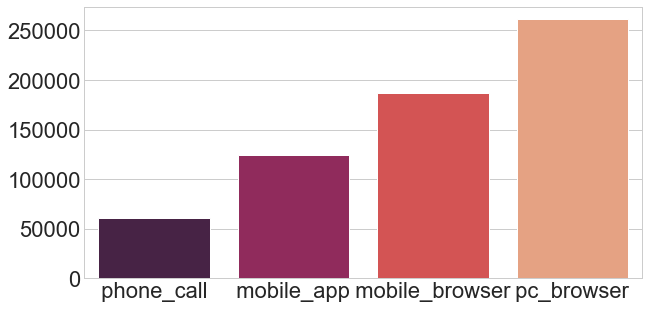

time: 687 ms


In [70]:
bar_plot(msgLog['device'].value_counts(ascending = True), '')

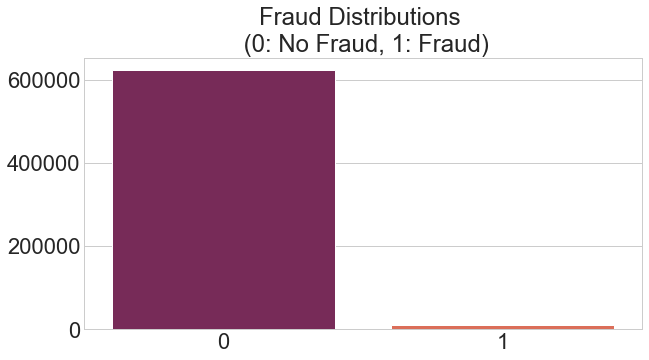

time: 232 ms


In [71]:
bar_plot(msgLog['fraud'].value_counts(ascending = True), 'Fraud Distributions \n (0: No Fraud, 1: Fraud)')

Analysing only the fraudulent customers

In [72]:
#fraudulent customers only
fraud_df = msgLog[msgLog['fraud'] == 1]
fraud_df.index = range(fraud_df.shape[0])

time: 844 ms


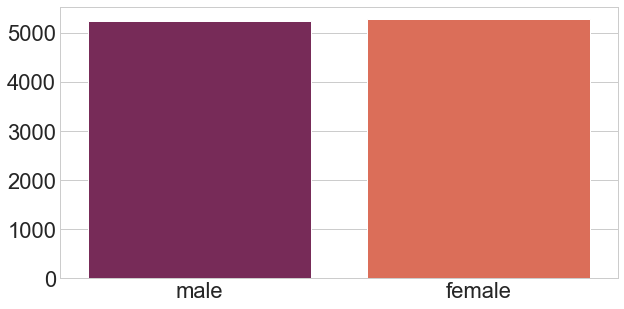

time: 203 ms


In [73]:
#graph of males and females
bar_plot(fraud_df['holder_gender'].value_counts(ascending = True), "")

In [74]:
#bar_plot_horizontal(fraud_df['suburb'].value_counts(ascending = True), '')

time: 1.29 ms


In [75]:
non_fraud_df = msgLog[msgLog['fraud']==0]

time: 320 ms


# Encoding

This section will:
1. encode all relevant data using label encoder or one hot encoding as appropriate - complete
2. Add (scaled) error between predicted gender and actual gender - incomplete

Encode stuff in tuples and list. 1 for male 0 for female. Will use self-made encoder.

# Create 'saved' dataframe to reduce wait time (dev only)

In [76]:
#cause I ceebs waiting
saved = msgLog.head(1000) 
saved.head()


,device,fraud,min_difference,max_difference,no_actions,average,new_id,paid_min,paid_max,paid_mean,holder_gender,holder_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,occupant_age,occupant_gender,occupant_first_name,occupant_last_name,holder_first_name,holder_last_name,street,street_number,suburb,email_prefix,email_provider,occupant_pred_gender,holder_pred_gender
69991,mobile_app,0,749.79,749.79,2,749.79,0,nan,nan,nan,male,53,1,346.20595281589794,5,1,"[14, 9]","[female, male]","[Kristen, Randy]","[Mathews, Mathews]",Kimberly,Mathews,Reidville,16,Richard Pine Suite,Kimberly Mathews,hotmail.com,"[M, F]",F
47893,mobile_app,0,840.34,840.34,2,840.34,1,nan,nan,nan,male,30,1,404.2134657047327,2,1,[],[],NaN,NaN,James,Terrell,Lake Matthewmouth,114,PSC,James Terrell,ryan-alvarado.com,NaN,M
580488,phone_call,0,152.05,12309870.35,41,1264781.63,2,5334.98,5334.98,5334.98,female,33,0,173.39906418207295,2,1,"[9, 13]","[male, female]","[Jodi, Mary]","[Washington, Washington]",Bruce,Washington,North Danielborough,138,West Mountains Suite,Bruce Washington,yahoo.com,"[F, F]",F
604874,phone_call,0,106.50,2186081.22,24,904472.77,3,7972.84,7972.84,7972.84,male,48,0,258.9137675110828,3,1,"[46, 9, 17]","[male, male, female]","[Clinton, Laura, Edward]","[Mendoza, Mendoza, Mendoza]",Keith,Mendoza,North Carolside,86,Taylor Mill,Keith Mendoza,holloway.com,"[M, F, M]",M
370148,pc_browser,0,773.41,773.41,2,773.41,4,nan,nan,nan,female,30,1,496.9237894372949,2,1,[31],[male],[Matthew],[Murray],Daniel,Murray,Reidville,17,Barbara Circles,Daniel Murray,hotmail.com,[M],M


time: 62.1 ms


In [77]:
"""
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(('male', 'male', 'female', 'female'))
le.classes_
"""

"\nfrom sklearn import preprocessing\nle = preprocessing.LabelEncoder()\nle.fit(('male', 'male', 'female', 'female'))\nle.classes_\n"

time: 4.44 ms


In [78]:
#le.fit('female')
#saved['holder_gender'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else le.transform(text))

def encode_nested_lists(dataframe):
    
    """
    function that allows for the encoding of nested lists

    Will use df.apply for efficiency
    
    male = 1
    female = 0
    M = 1
    F = 0
    """

    dataframe ['occupant_gender'] = dataframe['occupant_gender'].apply(lambda tuple1: np.nan if (tuple1 is np.nan or len(tuple1)==0) else [(1 if value == 'male' else 0) for value in tuple1])
    dataframe['occupant_pred_gender'] = dataframe['occupant_pred_gender'].apply(lambda list1: np.nan if (list1 is np.nan or len(list1)==0) else [(1 if value == 'M' else 0) for value in list1])

    return dataframe

time: 5.84 ms


In [79]:
msgLog = encode_nested_lists(msgLog)
msgLog.head()

,device,fraud,min_difference,max_difference,no_actions,average,new_id,paid_min,paid_max,paid_mean,holder_gender,holder_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,occupant_age,occupant_gender,occupant_first_name,occupant_last_name,holder_first_name,holder_last_name,street,street_number,suburb,email_prefix,email_provider,occupant_pred_gender,holder_pred_gender
69991,mobile_app,0,749.79,749.79,2,749.79,0,nan,nan,nan,male,53,1,346.20595281589794,5,1,"[14, 9]","[0, 1]","[Kristen, Randy]","[Mathews, Mathews]",Kimberly,Mathews,Reidville,16,Richard Pine Suite,Kimberly Mathews,hotmail.com,"[1, 0]",F
47893,mobile_app,0,840.34,840.34,2,840.34,1,nan,nan,nan,male,30,1,404.2134657047327,2,1,[],NaN,NaN,NaN,James,Terrell,Lake Matthewmouth,114,PSC,James Terrell,ryan-alvarado.com,NaN,M
580488,phone_call,0,152.05,12309870.35,41,1264781.63,2,5334.98,5334.98,5334.98,female,33,0,173.39906418207295,2,1,"[9, 13]","[1, 0]","[Jodi, Mary]","[Washington, Washington]",Bruce,Washington,North Danielborough,138,West Mountains Suite,Bruce Washington,yahoo.com,"[0, 0]",F
604874,phone_call,0,106.50,2186081.22,24,904472.77,3,7972.84,7972.84,7972.84,male,48,0,258.9137675110828,3,1,"[46, 9, 17]","[1, 1, 0]","[Clinton, Laura, Edward]","[Mendoza, Mendoza, Mendoza]",Keith,Mendoza,North Carolside,86,Taylor Mill,Keith Mendoza,holloway.com,"[1, 0, 1]",M
370148,pc_browser,0,773.41,773.41,2,773.41,4,nan,nan,nan,female,30,1,496.9237894372949,2,1,[31],[1],[Matthew],[Murray],Daniel,Murray,Reidville,17,Barbara Circles,Daniel Murray,hotmail.com,[1],M


time: 2.6 s


label encode gender columns. Use scikit learn label encoder

In [80]:
from sklearn.preprocessing import LabelEncoder

def label_encode(dataframe, list_of_encoded_items):
    
    """
    function to label encode: 'holder_gender', 'holder_pred_gender', 'suburb', 'email_provider', 'device', 'street'
    
    Male = 1
    Female = 0
    M = 1
    F = 0
    """
    
    for i in list_of_encoded_items:
        dataframe[i] = LabelEncoder().fit_transform(dataframe[i])
    
    """
    dataframe['holder_gender'] = LabelEncoder().fit_transform(dataframe['holder_gender'])
    dataframe['holder_pred_gender'] = LabelEncoder().fit_transform(dataframe['holder_pred_gender'])
    dataframe['suburb'] = LabelEncoder().fit_transform(dataframe['suburb'])
    dataframe['email_provider'] = LabelEncoder().fit_transform(dataframe['email_provider'])

    dataframe['device'] = LabelEncoder().fit_transform(dataframe['device'])
    dataframe['street'] = LabelEncoder().fit_transform(dataframe['street'])
    """
    
    return dataframe

time: 4.84 ms


In [81]:
msgLog = label_encode(msgLog, ['holder_gender', 'holder_pred_gender', 'suburb', 'email_provider', 'device', 'street'])
msgLog.head()

,device,fraud,min_difference,max_difference,no_actions,average,new_id,paid_min,paid_max,paid_mean,holder_gender,holder_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,occupant_age,occupant_gender,occupant_first_name,occupant_last_name,holder_first_name,holder_last_name,street,street_number,suburb,email_prefix,email_provider,occupant_pred_gender,holder_pred_gender
69991,0,0,749.79,749.79,2,749.79,0,nan,nan,nan,1,53,1,346.20595281589794,5,1,"[14, 9]","[0, 1]","[Kristen, Randy]","[Mathews, Mathews]",Kimberly,Mathews,56,16,358,Kimberly Mathews,39602,"[1, 0]",0
47893,0,0,840.34,840.34,2,840.34,1,nan,nan,nan,1,30,1,404.2134657047327,2,1,[],NaN,NaN,NaN,James,Terrell,32,114,467,James Terrell,76841,NaN,1
580488,3,0,152.05,12309870.35,41,1264781.63,2,5334.98,5334.98,5334.98,0,33,0,173.39906418207295,2,1,"[9, 13]","[1, 0]","[Jodi, Mary]","[Washington, Washington]",Bruce,Washington,48,138,447,Bruce Washington,96875,"[0, 0]",0
604874,3,0,106.50,2186081.22,24,904472.77,3,7972.84,7972.84,7972.84,1,48,0,258.9137675110828,3,1,"[46, 9, 17]","[1, 1, 0]","[Clinton, Laura, Edward]","[Mendoza, Mendoza, Mendoza]",Keith,Mendoza,47,86,411,Keith Mendoza,38969,"[1, 0, 1]",1
370148,2,0,773.41,773.41,2,773.41,4,nan,nan,nan,0,30,1,496.9237894372949,2,1,[31],[1],[Matthew],[Murray],Daniel,Murray,56,17,18,Daniel Murray,39602,[1],1


time: 2.91 s


one hot encode different columns. If genderize isn't working use the 2nd cell otherwise use the first cell. \n
not sure if label encoding is better or not

In [82]:
"""
def one_hot_encode(dataframe):
    

    function to one hot encode column: device
  
    
    dataframe = pd.get_dummies(dataframe, prefix_sep="_", columns=['device'])
    
    return dataframe"""

'\ndef one_hot_encode(dataframe):\n    \n\n    function to one hot encode column: device\n  \n    \n    dataframe = pd.get_dummies(dataframe, prefix_sep="_", columns=[\'device\'])\n    \n    return dataframe'

time: 5.2 ms


In [83]:
"""
saved = one_hot_encode(saved)
saved.head()
"""

'\nsaved = one_hot_encode(saved)\nsaved.head()\n'

time: 37.7 ms


# Error in Gender (still working on this)

Find error in gender for each person and their occupants in their house

Error is defined as difference between predicted gender and actual gender. 

More details can be found in the code comments

In [84]:
def list_compare(list1, list2):
    
    """
    helper function to compare the values two lists
    
    creates another list of same length. If values are equal 0 is recorded else 1 is recorded. Then summed and divided by length.
    
    Eg. 
    list1 = [0,1,0,0]
    list2 = [0,0,0,0]
    
    returned_list = [0,1,0,0]
    returned_error = 1/4 = 0.25
    """
    
    #early exit
    if(len(list1)==0 or len(list2)==0):
        return 0
    
    #dealing with mismatching lengths (there's a hole in this method - that links to the caution mentioned above - but I ceebs making this code perfect)
    smallest = min(len(list1), len(list2))
    
    #new list
    list3 = []
    
    #print(len(list1))
    #print(len(list2))
    
    #loop through lists
    for i in range(smallest):
        
        #if not equal
        if(list1[i]!=list2[i]):
            list3.append(1)
            
        #if equal
        else:
            list3.append(0)
            
    #print(sum(list3))
    #print(len(list3))
    #print(list3)
    
    return sum(list3)/len(list3)
    

time: 18 ms


In [85]:
def gender_error(dataframe):
    
    """
    driver function to find the error between predicted gender and actual gender for both occupants and holders
    """
    
    dataframe['holder_error_in_gender'] = abs(dataframe['holder_gender'] - msgLog['holder_pred_gender'])
    dataframe['occupant_error_in_gender'] = dataframe.apply(lambda row: np.nan if (row['occupant_gender'] is np.nan or len(row['occupant_gender'])==0) else list_compare(row['occupant_gender'], row['occupant_pred_gender']), axis = 1)

    return dataframe


time: 6.03 ms


# Occupant Age (still working on this)

get min, max and avg age for occupants

In [118]:
"""from statistics import mean

testing = saved[['new_id', 'occupant_age']]

testing['occupant_age'][1] = list(map(int, testing['occupant_age'][1]))

#testing['occupant_age'] = map(int, testing['occupant_age'])
testing['occupant_age']
#testing['occupant_age'].apply(lambda list1: np.nan if (list1 is np.nan or len(list1)==0) else (sum(list1)))
"""

KeyError: 1

time: 67.1 ms


In [86]:
msgLog = gender_error(msgLog)
msgLog.head()

,device,fraud,min_difference,max_difference,no_actions,average,new_id,paid_min,paid_max,paid_mean,holder_gender,holder_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,occupant_age,occupant_gender,occupant_first_name,occupant_last_name,holder_first_name,holder_last_name,street,street_number,suburb,email_prefix,email_provider,occupant_pred_gender,holder_pred_gender,holder_error_in_gender,occupant_error_in_gender
69991,0,0,749.79,749.79,2,749.79,0,nan,nan,nan,1,53,1,346.20595281589794,5,1,"[14, 9]","[0, 1]","[Kristen, Randy]","[Mathews, Mathews]",Kimberly,Mathews,56,16,358,Kimberly Mathews,39602,"[1, 0]",0,1,1.00
47893,0,0,840.34,840.34,2,840.34,1,nan,nan,nan,1,30,1,404.2134657047327,2,1,[],NaN,NaN,NaN,James,Terrell,32,114,467,James Terrell,76841,NaN,1,0,nan
580488,3,0,152.05,12309870.35,41,1264781.63,2,5334.98,5334.98,5334.98,0,33,0,173.39906418207295,2,1,"[9, 13]","[1, 0]","[Jodi, Mary]","[Washington, Washington]",Bruce,Washington,48,138,447,Bruce Washington,96875,"[0, 0]",0,0,0.50
604874,3,0,106.50,2186081.22,24,904472.77,3,7972.84,7972.84,7972.84,1,48,0,258.9137675110828,3,1,"[46, 9, 17]","[1, 1, 0]","[Clinton, Laura, Edward]","[Mendoza, Mendoza, Mendoza]",Keith,Mendoza,47,86,411,Keith Mendoza,38969,"[1, 0, 1]",1,0,0.67
370148,2,0,773.41,773.41,2,773.41,4,nan,nan,nan,0,30,1,496.9237894372949,2,1,[31],[1],[Matthew],[Murray],Daniel,Murray,56,17,18,Daniel Murray,39602,[1],1,1,0.00


time: 49 s


# Drop columns

drop certain columns. consider keeping these and using them for modelling

In [87]:
msgLog = msgLog.drop(['occupant_first_name', 'occupant_last_name', 'holder_first_name', 'holder_last_name', 'email_prefix', 'occupant_pred_gender', 'occupant_gender', 'occupant_age'], axis = 1)
msgLog.head()

,device,fraud,min_difference,max_difference,no_actions,average,new_id,paid_min,paid_max,paid_mean,holder_gender,holder_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,street,street_number,suburb,email_provider,holder_pred_gender,holder_error_in_gender,occupant_error_in_gender
69991,0,0,749.79,749.79,2,749.79,0,nan,nan,nan,1,53,1,346.20595281589794,5,1,56,16,358,39602,0,1,1.00
47893,0,0,840.34,840.34,2,840.34,1,nan,nan,nan,1,30,1,404.2134657047327,2,1,32,114,467,76841,1,0,nan
580488,3,0,152.05,12309870.35,41,1264781.63,2,5334.98,5334.98,5334.98,0,33,0,173.39906418207295,2,1,48,138,447,96875,0,0,0.50
604874,3,0,106.50,2186081.22,24,904472.77,3,7972.84,7972.84,7972.84,1,48,0,258.9137675110828,3,1,47,86,411,38969,1,0,0.67
370148,2,0,773.41,773.41,2,773.41,4,nan,nan,nan,0,30,1,496.9237894372949,2,1,56,17,18,39602,1,1,0.00


time: 167 ms


# REMINDER: FIX UNDERLYING PROBLEM

This is a bandaid for a bug that shouldn't exist in the first place. 

In [88]:
def fix_stupid_issue(dataframe, list_of_cols_to_fix):
    
    """
    function to fix an issue that shouldn't occur in the first place
    """
    
    for i in list_of_cols_to_fix:
        dataframe[i] = dataframe[i].astype(float)
        
    return dataframe
        
msgLog = fix_stupid_issue(msgLog, ['house_square_footage', 'holder_age', 'house_type', 'house_number_of_bedrooms', 'house_number_of_floors', 'street_number'])                                   

time: 692 ms


# Export to CSV

export to csv for concurrent analysis in R

In [120]:
import os
msgLog.to_csv(os.getcwd()+'export.csv',index = False)

time: 23.2 s


-------
# Part 2: Data Modelling
-------

# Splitting the Data 

Split into train and test sets
adapted from: https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

print('No Frauds', round(msgLog['fraud'].value_counts()[0]/len(msgLog) * 100,2), '% of the dataset')
print('Frauds', round(msgLog['fraud'].value_counts()[1]/len(msgLog) * 100,2), '% of the dataset')

X = msgLog.drop('fraud', axis = 1)
Y = msgLog['fraud']

#split data into training and testing sets in a 80:20 ratio
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = 5)
trainX.head()

No Frauds 98.34 % of the dataset
Frauds 1.66 % of the dataset


,device,min_difference,max_difference,no_actions,average,new_id,paid_min,paid_max,paid_mean,holder_gender,holder_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,street,street_number,suburb,email_provider,holder_pred_gender,holder_error_in_gender,occupant_error_in_gender
406313,2,825.43,825.43,2,825.43,611086,nan,nan,nan,1,34.00,1.00,475.10,2.00,1.00,32,59.00,339,51065,0,1,0.00
479424,2,0.00,8613.84,5,2389.63,147609,nan,nan,nan,0,33.00,1.00,262.42,3.00,1.00,31,132.00,293,29894,0,0,0.40
473845,2,240.42,240.42,2,240.42,161748,nan,nan,nan,1,46.00,1.00,315.56,2.00,1.00,70,41.00,224,39602,1,0,nan
250627,1,546.72,546.72,2,546.72,29535,nan,nan,nan,1,43.00,1.00,434.95,3.00,1.00,45,25.00,170,84005,1,0,1.00
424968,2,129.42,5741557.42,6,2253637.98,187584,7991.00,7991.00,7991.00,0,57.00,1.00,259.64,3.00,1.00,59,13.00,467,39602,0,0,0.00


time: 492 ms


Create sample dataframe (of 1000 entries). Dataframe is balanced: 500 fraudulent entries and 500 non-fraudulent entries. 

In [91]:
def shuffle_dataframe(dataframe):
    
    """
    function to shuffle a dataframe.
    
    Uses random state = 42 and frac = 1
    """

    return dataframe.sample(frac = 1, random_state = 42)

def balanced_sample(df):
    
    """
    function that creates a sample of 1000 entries. 
    
    The sample is balanced so it has 500 fraudulent entries and 500 non-fraudulent entries.
    
    If the dataframe entered is too small the function will aim to deliver equal amounts of fraud and non-fraudulent entries
    """
    
    #get fraud df
    fraud_df = df.loc[df['fraud'] == 1][:500]
    
    #get non_fraud df
    non_fraud_df = df.loc[df['fraud'] == 0][:len(fraud_df)]
    
    #concat both df
    normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

    #shuffle dataframe
    new_df = shuffle_dataframe(normal_distributed_df)

    return new_df

time: 10.4 ms


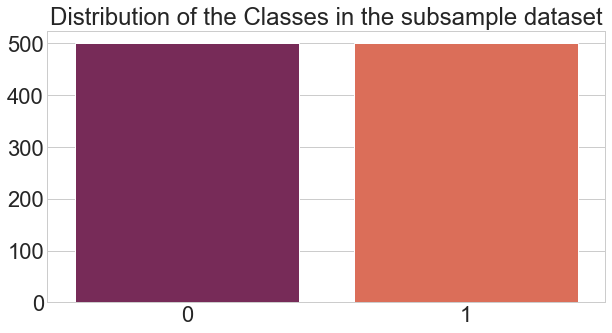

time: 682 ms


In [92]:
#for testing purposes create sample dataframe
#shuffle and balance this dataframe
sample = balanced_sample(shuffle_dataframe(msgLog))
bar_plot(sample['fraud'].value_counts(ascending = True), 'Distribution of the Classes in the subsample dataset')

# Correlation Matrix

To find which features are helpful in predicting fraud

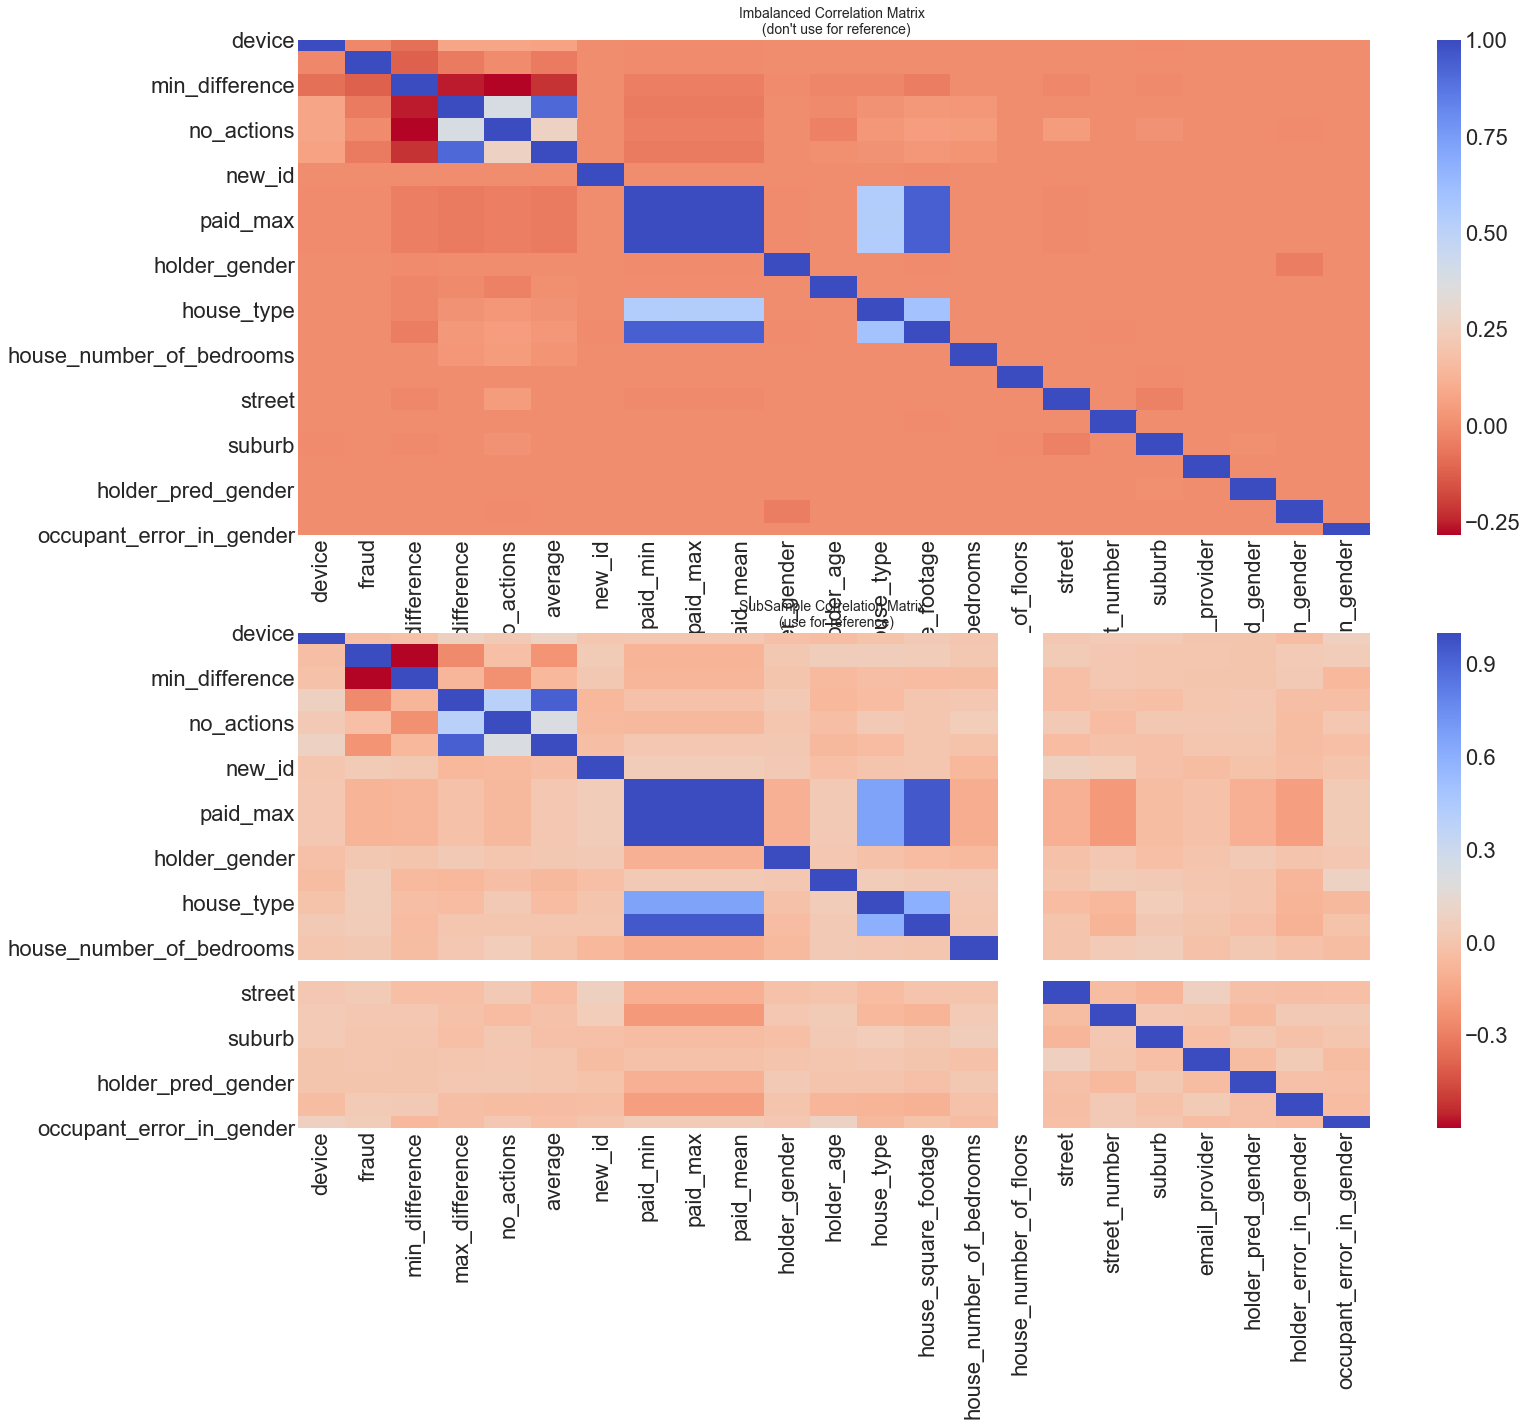

time: 2.58 s


In [93]:
#copied from: https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

#change font size
plt.rcParams.update({'font.size': 20})

# Entire DataFrame
corr = msgLog.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

sub_sample_corr = sample.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

There seems to be a correlation between using a mobile_app or mobiel browser and committing insurance fraud. There also seems to be a strong negative correlation between min_difference and insurance fraud.

Comparing fradulent customers with genuine customers in order to find which variables are useful. Will use heatmap to conduct analysis.

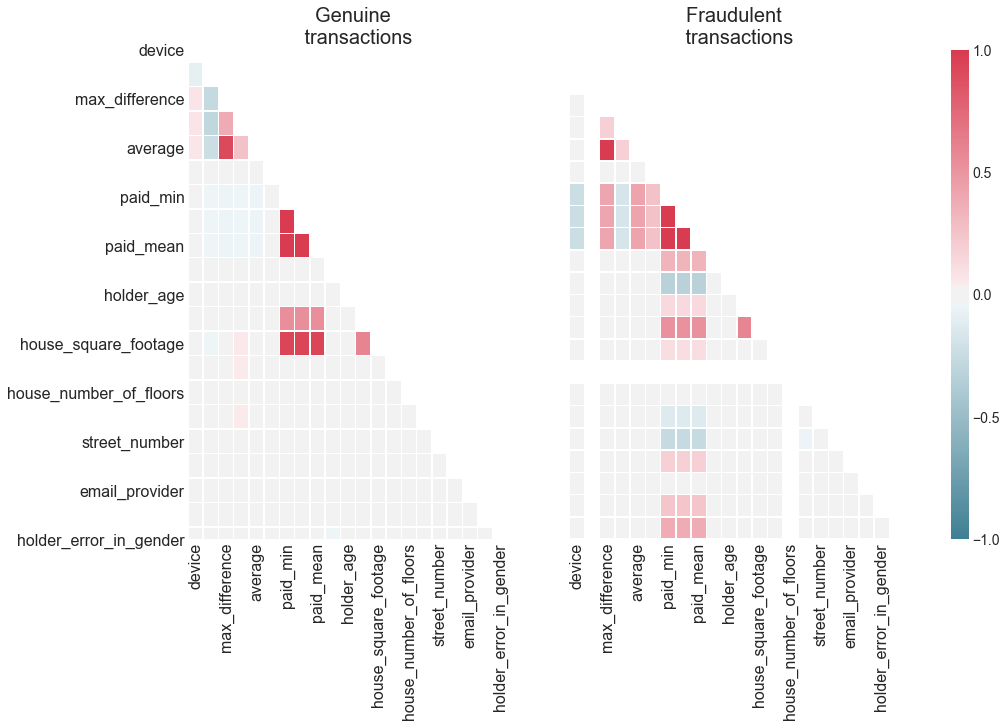

time: 2.08 s


In [94]:
#copied from: https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services
def correlation_matrix_contrasting(X, Y):
    
    """
    function to make two correlation matrices. 
    
    One of only fraudulent entries and another with only genuine entries. 
    
    Takes Y vector as a fraud column, and X matrix as the other variables.
    """
    
    Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
    XnonFraud = X.loc[Y == 0]

    correlationNonFraud = XnonFraud.loc[:, X.columns != 'fraud'].corr()
    mask = np.zeros_like(correlationNonFraud)
    indices = np.triu_indices_from(correlationNonFraud)
    mask[indices] = True

    grid_kws = {'width_ratios': (.9, .9, .05), 'wspace': 0.2}
    f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, figsize = (14, 9))

    cmap = sns.diverging_palette(220, 8, as_cmap = True)
    ax1 = sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
    ax1.set_xticklabels(ax1.get_xticklabels(), size = 16)
    ax1.set_yticklabels(ax1.get_yticklabels(), size = 16)
    ax1.set_title('Genuine \n transactions', size = 20)

    correlationFraud = Xfraud.loc[:, X.columns != 'fraud'].corr()
    ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', 'ticks': [-1, -0.5, 0, 0.5, 1]})
    ax2.set_xticklabels(ax2.get_xticklabels(), size = 16)
    ax2.set_title('Fraudulent \n transactions', size = 20)

    cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14)
    
correlation_matrix_contrasting(X, Y)


Clearly, there is a huge difference in correlation of variables between fraudulent and genuine entries. This should be useful in providing a trend from which we can build ML models

# Model 1: XGBoost 
copied from: https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services


"*Selection of ML algorithm*: A first approach to deal with imbalanced data is to balance it by discarding the majority class before applying an ML algorithm. The disadvantage of  undersampling is that a model trained in this way will not perform well on real-world skewed test data since almost all the information was discarded. A better approach might be to oversample the minority class, say by the synthetic minority oversampling technique (SMOTE) contained in the 'imblearn' library. Motivated by this, I tried a variety of anomaly-detection and supervised learning approaches. I find, however, that the best result is obtained on the original dataset by using a ML algorithm based on ensembles of decision trees that intrinsically performs well on imbalanced data. Such algorithms not only allow for constructing a model that can cope with the missing values in our data, but they naturally allow for speedup via parallel-processing. Among these algorithms, the extreme gradient-boosted (XGBoost) algorithm used below slightly outperforms random-forest. Finally, XGBoost, like several other ML algorithms, allows for weighting the positive class more compared to the negative class --- a setting that also allows to account for the skew in the data." - https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services

In [95]:
#takes a while
import xgboost as xgb
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score

weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = xgb.XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))

AUPRC = 0.9999976646338381
time: 59.1 s


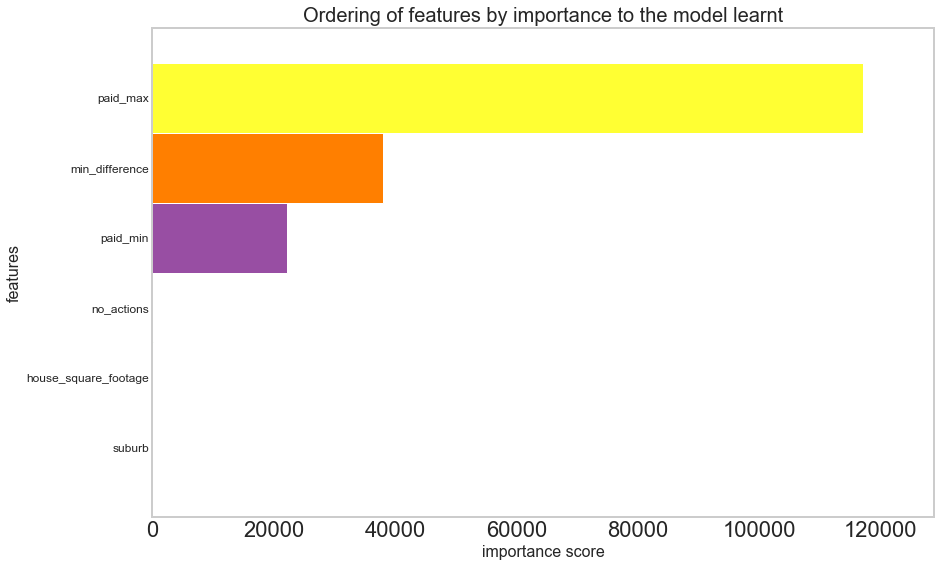

time: 732 ms


In [96]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = xgb.plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

Visualisation of ML model

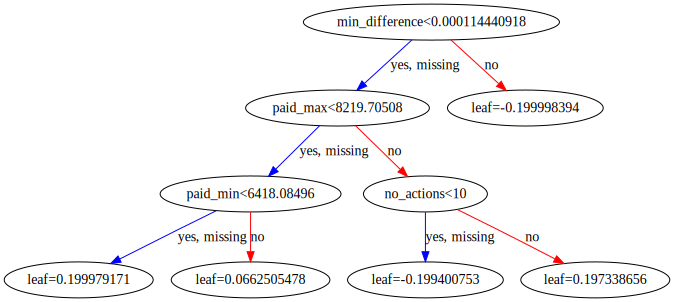

time: 2.51 s


In [97]:
xgb.to_graphviz(clf)

Make predictions using model

TODO:
-use SMOTE or similar cause the imbalanced data makes f1 score, accuracy and precision look very good

In [98]:
y_pred_xgb = clf.predict(testX)
predictions = [i for i in y_pred_xgb]

#cv
#from sklearn.model_selection import cross_val_predict
#log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function")

#classification stuff
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(testY, predictions)
print("Accuracy: %.9f%%" % (accuracy * 100.0))
print("f1_score: %.9f%%" % (f1_score(testY, predictions) * 100.0))
print("precision: %.9f%%" % (precision_score(testY, predictions) * 100.0))
print("recall: %.9f%%" % (recall_score(testY, predictions) * 100.0))

#roc_auc_score
print('roc_auc_score: ', skm.roc_auc_score(testY, predictions))

#AUPRC
print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))

#average precision recall score
average_precision = average_precision_score(testY, predictions)
print('Average precision-recall score: {0:0.9f}'.format(average_precision))

#confusion matrix (graph)

from sklearn.metrics import confusion_matrix

xgb_cm = skm.confusion_matrix(testY, y_pred_xgb)

fig, ax = plt.subplots(1, 1,figsize=(10,5))
sns.heatmap(xgb_cm, ax=ax, cmap=plt.cm.copper)
ax.set_title("XGBoost Classifier \n Confusion Matrix", fontsize=14)

#precision, recall, f1-score

from sklearn.metrics import classification_report

#print('XGBoost Classifier:')
#print(classification_report(testY, y_pred_xgb))

Accuracy: 99.998420221%
f1_score: 99.951573850%
precision: 100.000000000%
recall: 99.903194579%


NameError: name 'skm' is not defined

time: 6.06 s


In [ ]:
from sklearn.metrics import roc_curve

xgb_fpr, xgb_tpr, xgb_thresold = roc_curve(trainY, predictions)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()


From the graph, the model correctly classifies true negatives (top left square), while minimising false negatives (top right square) and false positives (bottom left square). However it fails to capture true positives (bottom right square) - which is pretty much the whole point of this assignment. So yeah, it needs work lol

# convert dataframe to csv file 
submission.to_csv('../Titanic/catboost_sub.csv', index = False)
print("Submission is ready!")